# Visualisation and analysis of the results from the DESI-MS linear mixed models

### Import required packages

In [1]:
import pandas as pds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

## Read the raw DESI-MS data

### VMET2 Cohort

In [2]:
desi_pos_vmet2 = pds.read_csv('../../Data/VMET2_DESI-MS_POS.csv')
desi_neg_vmet2 = pds.read_csv('../../Data/VMET2_DESI-MS_NEG.csv')

vmet2_metadata = pds.read_csv('../../Data/VMET2_CSTAssignment.csv')

desi_pos_vmet2 = vmet2_metadata.merge(desi_pos_vmet2, on='Seq_ID')
desi_neg_vmet2 = vmet2_metadata.merge(desi_neg_vmet2, on='Seq_ID')

### VMET Cohort

In [3]:
desi_pos_vmet = pds.read_csv('../../Data/VMET_DESI-MS_NEG.csv')
desi_neg_vmet = pds.read_csv('../../Data/VMET_DESI-MS_NEG.csv')

vmet_metadata = pds.read_csv('../../Data/VMET_CSTAssignment.csv')

desi_pos_vmet = vmet_metadata.merge(desi_pos_vmet, left_on='Seq_ID', right_on='Seq_ID')
desi_neg_vmet = vmet_metadata.merge(desi_neg_vmet, left_on='Seq_ID', right_on='Seq_ID')

## Replication of results across the VMET2 and VMET studies

Find matching peaks (peaks within a certain m/z error from each other) from the VMET and VMET2 datasets which were found to be statistically significant in the linear mixed model analysis of both datasets.

In [4]:
# Define these 2 utility functions to do the matching and comparison of output files from the
# "Linear mixed effect models DESI-MS.Rmd" notebook.

def checkResults(file1, file2, excelFile, datasetNames, sigLevel=0.05, tolerance=5):
    
    file1_res = pds.read_csv(file1)
    file2_res = pds.read_csv(file2)
    
    contrasts_file1_names = file1_res.columns
    contrasts_file2_names = file2_res.columns
    
    contrast_names = contrasts_file1_names[contrasts_file1_names.isin(contrasts_file2_names)]
    contrast_names = [x for x in contrast_names if '_pval' in x]
    match_list = list()
    file1_only_list = list()
    file2_only_list = list()
    
    with pds.ExcelWriter(excelFile) as writer:
        
        for contrast in contrast_names:
            
            file1_sig_names = file1_res.loc[file1_res[contrast] < sigLevel, 'Metabolite']
            file2_sig_names = file2_res.loc[file2_res[contrast] < sigLevel, 'Metabolite']
            
            matches = matchPeaks(file1_sig_names, file2_sig_names, datasetNames, tolerance)
            matches.to_excel(writer, sheet_name=contrast + 'Shared')
            match_list.append([contrast, matches])
            file1_only = pds.DataFrame(file1_sig_names[~file1_sig_names.isin(matches[datasetNames[0] + '_Metabolite'])])
            file2_only = pds.DataFrame(file2_sig_names[~file2_sig_names.isin(matches[datasetNames[1] + '_Metabolite'])])
            file1_only_list.append([contrast, file1_only])
            file2_only_list.append([contrast, file2_only])
            file1_only.to_excel(writer, sheet_name=contrast + ' ' + datasetNames[0])
            file2_only.to_excel(writer, sheet_name=contrast + ' ' + datasetNames[1])

    return match_list, file1_only_list, file2_only_list

def matchPeaks(vec1, vec2, datasetNames, tolerance=5):
    
    A = vec1.reset_index(drop=True)
    B = vec2.reset_index(drop=True)
    
    
    matches = [(idx, x, np.argmin(np.abs(x - B)), B[np.argmin(np.abs(x - B))]) for idx, x in enumerate(A) if np.min(np.abs(x-B))/x*1e6 < tolerance]
    matches = pds.DataFrame(matches, columns=[datasetNames[0] + '_idx', datasetNames[0] + '_Metabolite', datasetNames[1] + '_idx', datasetNames[1] + '_Metabolite'])
    return matches

## Identify statistically significant features shared between the VMET2 and VMET datasets

By default a metabolic feature is considered replicated in both VMET and VMET2 if for a statistically significant marker (Benjamini-Hochberg FDR q-value < 0.05) there is another signal within less than 5 ppm error in the other dataset which also has a BH q-value < 0.05.

Two files with the positive and negative ion mode overlap are exported, **DESI_NEG_BH_LinearModelReplication.xlsx** and **DESI_POS_BH_LinearModelReplication.xlsx**.

In [5]:
vmet2_res_neg =  './LinearMixedModels_DESI-MS/VMET2_DESI_NEG_LME_CST.csv'
vmet_res_neg = './LinearMixedModels_DESI-MS/VMET_DESI_NEG_LME_CST.csv'

vmet2_res_pos = './LinearMixedModels_DESI-MS/VMET2_DESI_POS_LME_CST.csv'
vmet_res_pos = './LinearMixedModels_DESI-MS/VMET_DESI_POS_LME_CST.csv'

vmet2_res_pos_bh = './LinearMixedModels_DESI-MS/VMET2_DESI_POS_LME_CST_BH.csv'  
vmet_res_pos_bh =  './LinearMixedModels_DESI-MS/VMET_DESI_POS_LME_CST_BH.csv'

vmet2_res_neg_bh = './LinearMixedModels_DESI-MS/VMET2_DESI_NEG_LME_CST_BH.csv' 
vmet_res_neg_bh = './LinearMixedModels_DESI-MS/VMET_DESI_NEG_LME_CST_BH.csv'

dneg_matches = checkResults(vmet2_res_neg, vmet_res_neg, './LinearMixedModels_DESI-MS/DESI_NEG_LinearModelReplication.xlsx', ['VMET2', 'VMET'])
dpos_matches = checkResults(vmet2_res_pos, vmet_res_pos, './LinearMixedModels_DESI-MS/DESI_POS_LinearModelReplication.xlsx', ['VMET2', 'VMET'])

dneg_bh_matches = checkResults(vmet2_res_neg_bh, vmet_res_neg_bh, './LinearMixedModels_DESI-MS/DESI_NEG_BH_LinearModelReplication.xlsx', ['VMET2', 'VMET'])
dpos_bh_matches = checkResults(vmet2_res_pos_bh, vmet_res_pos_bh, './LinearMixedModels_DESI-MS/DESI_POS_BH_LinearModelReplication.xlsx', ['VMET2', 'VMET'])



In [6]:
# Prepare the feature selection vectors 
# Commented code can be used to account for floating point precision differences 
# between exported results and raw data frame if required.

Dataset = 'VMET2'
dnegMetLDep_vmet2 = dneg_bh_matches[0][15][1][Dataset + '_Metabolite']
dposMetLDep_vmet2 = dpos_bh_matches[0][15][1][Dataset + '_Metabolite']

# Round metabolites and convert to string to allow column indexing by "mz" 
#dnegMetLDep_vmet2 = dnegMetLDep_vmet2.round(8)
#dnegMetLDep_vmet2 = dnegMetLDep_vmet2.astype(str)

#dposMetLDep_vmet2 = dposMetLDep_vmet2.round(2)
#dposMetLDep_vmet2 = dposMetLDep_vmet2.astype(str)

Dataset = 'VMET'
dnegMetLDep_vmet = dneg_bh_matches[0][15][1][Dataset + '_Metabolite']
dposMetLDep_vmet = dpos_bh_matches[0][15][1][Dataset + '_Metabolite']

# Round metabolites and convert to string to allow column indexing by "mz" 
#dnegMetLDep_vmet = dnegMetLDep_vmet.round(10)
#dnegMetLDep_vmet = dnegMetLDep_vmet.astype(str)

#dposMetLDep_vmet = dposMetLDep_vmet.round(10)
#dposMetLDep_vmet = dposMetLDep_vmet.astype(str)

In [7]:
desi_neg_vmet2_metabolites = np.array([float(x) for x in desi_neg_vmet2.columns[8:-1]])
desi_pos_vmet2_metabolites = np.array([float(x) for x in desi_pos_vmet2.columns[8:-1]])
desi_neg_vmet_metabolites = np.array([float(x) for x in desi_neg_vmet.columns[8:-1]])
desi_pos_vmet_metabolites = np.array([float(x) for x in desi_pos_vmet.columns[8:-1]])

dnegMetLDep_vmet2 = np.array([desi_neg_vmet2_metabolites[np.argmin(np.abs(desi_neg_vmet2_metabolites - float(x)))] for x in dnegMetLDep_vmet2])
dposMetLDep_vmet2 = np.array([desi_pos_vmet2_metabolites[np.argmin(np.abs(desi_pos_vmet2_metabolites - float(x)))] for x in dposMetLDep_vmet2])

dnegMetLDep_vmet = np.array([desi_neg_vmet_metabolites[np.argmin(np.abs(desi_neg_vmet_metabolites - float(x)))] for x in dnegMetLDep_vmet])
dposMetLDep_vmet = np.array([desi_pos_vmet_metabolites[np.argmin(np.abs(desi_pos_vmet_metabolites - float(x)))] for x in dposMetLDep_vmet])

dnegMetLDep_vmet2 = dnegMetLDep_vmet2.astype(str)
dposMetLDep_vmet2 = dposMetLDep_vmet2.astype(str)
dnegMetLDep_vmet = dnegMetLDep_vmet.astype(str)
dposMetLDep_vmet = dposMetLDep_vmet.astype(str)

### Generate the heatmap plots from the VMET and VMET2 linear mixed model analysis, as seen in Figure 1 B

In [8]:
# Helper function to re-order the dataframes according to CST for easier comparison
def assembleMat(dataframe, covariate, categoryOrder=['I', 'II', 'III', 'V', 'VI', 'IV']):
    asCategorical = pds.Categorical(dataframe[covariate])
    
    reordered_frame = list()
    
    #for category in asCategorical.categories:
    for category in categoryOrder:
        reordered_frame.append(dataframe.loc[dataframe[covariate] == category, :])
        
    reordered_frame = pds.concat(reordered_frame, axis=0)
    
    return reordered_frame


In [9]:
# Add a LDominant vs LDepleted information variable
desi_neg_vmet2['LDom'] = 'NA'
desi_neg_vmet2.loc[desi_neg_vmet2['CST'].isin(['I', 'II', 'III', 'V', 'VII']), 'LDom'] = 'Lactobacillus Dominant'
desi_neg_vmet2.loc[desi_neg_vmet2['CST'].isin(['VI', 'IV']), 'LDom'] = 'Lactobacillus Depleted'

desi_neg_vmet['LDom'] = 'NA'
desi_neg_vmet.loc[desi_neg_vmet['CST'].isin(['I', 'II', 'III', 'V', 'VII']), 'LDom'] = 'Lactobacillus Dominant'
desi_neg_vmet.loc[desi_neg_vmet['CST'].isin(['VI', 'IV']), 'LDom'] = 'Lactobacillus Depleted'

The plotHeatmap function is defined first and then used with the results from VMET and VMET2 to generate the heatmaps shown in Figure 1 B.

In [10]:
def plotHeatmap(dataset, features, row_covariate, row_covariate2=None, categoryOrder=['I', 'II', 'III', 'V', 'VII', 'VI', 'IV'], row_cluster=True):
    
    nColors = len(dataset[row_covariate].unique())
    cmap = ListedColormap(sns.color_palette("deep", nColors))

    dataset_ordered = assembleMat(dataset, row_covariate, categoryOrder)
    Xmat = dataset_ordered.loc[:, features]
    
    col_colors_vec = dataset_ordered[row_covariate]
    col_colors = [col_colors_vec.astype('category').cat.codes.map(cmap)]
    
    
    if row_covariate2 is not None:
        nColors2 = len(dataset[row_covariate2].unique())
        cmap_cat2= ListedColormap(sns.color_palette("Set1", nColors2))
        col_colors_vec_2 = dataset_ordered[row_covariate2]
        col_colors_2 = col_colors_vec_2.astype('category').cat.codes.map(cmap_cat2)
        col_colors.append(col_colors_2)
    
    metaboMap = sns.clustermap(Xmat.T, row_cluster=row_cluster, method='ward', z_score=0, 
                        yticklabels=False, col_colors=col_colors, cmap='RdPu',
                           xticklabels=False, col_cluster=False)
    
    
    bottom, top = metaboMap.ax_heatmap.get_ylim()
    #metaboMap.ax_heatmap.set_ylim(bottom + 0.5, top - 0.5)
    
    for idx, label in enumerate(col_colors_vec.astype('category').cat.categories):
        metaboMap.ax_col_dendrogram.bar(0, 0, color=cmap(idx), label= label, linewidth=0)
    
    for idx, label in enumerate(col_colors_vec_2.astype('category').cat.categories):
        metaboMap.ax_col_colors.bar(0, 0, color=cmap_cat2(idx), label=label, linewidth=0)

        
    metaboMap.ax_col_dendrogram.legend(loc='center', ncol=8)
    metaboMap.ax_col_colors.legend(loc='upper center', bbox_to_anchor=(0.5, +2.5), ncol=2)

    metaboMap.cax.set_ylabel('z(intensity)')

    
    return metaboMap
    

Generate the VMET2 heatmap

/home/gd2212/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


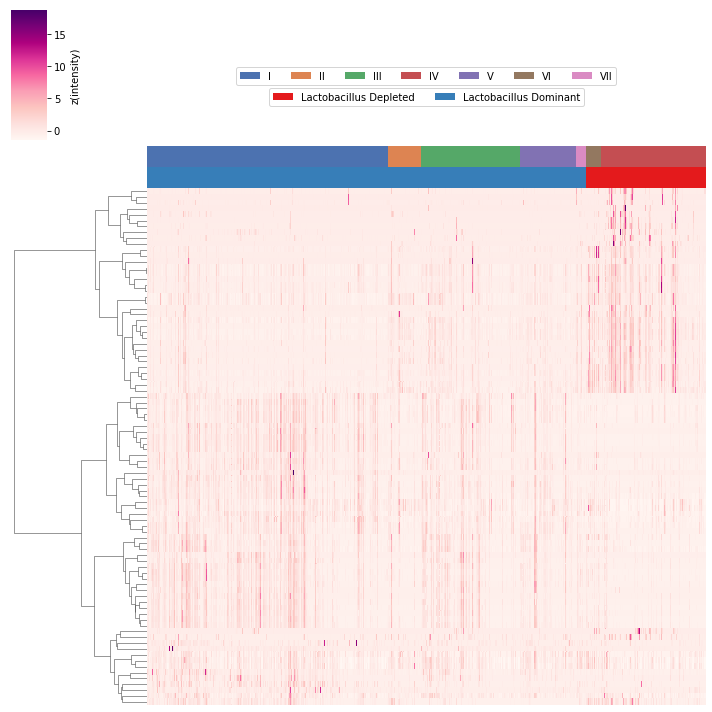

In [11]:
image_vmet2 = plotHeatmap(desi_neg_vmet2, dnegMetLDep_vmet2, 'CST', 'LDom')
image_vmet2.savefig('./LinearMixedModels_DESI-MS/ExampleFeaturesVMET2_Heatmap_Figure1.png', dpi=150)
#image_vmet2.savefig('VMET2_Heatmap_Figure1.eps', dpi=150)
#image_vmet2.savefig('VMET2_Heatmap_Figure1.svg', dpi=150)

Generate the VMET heatmap

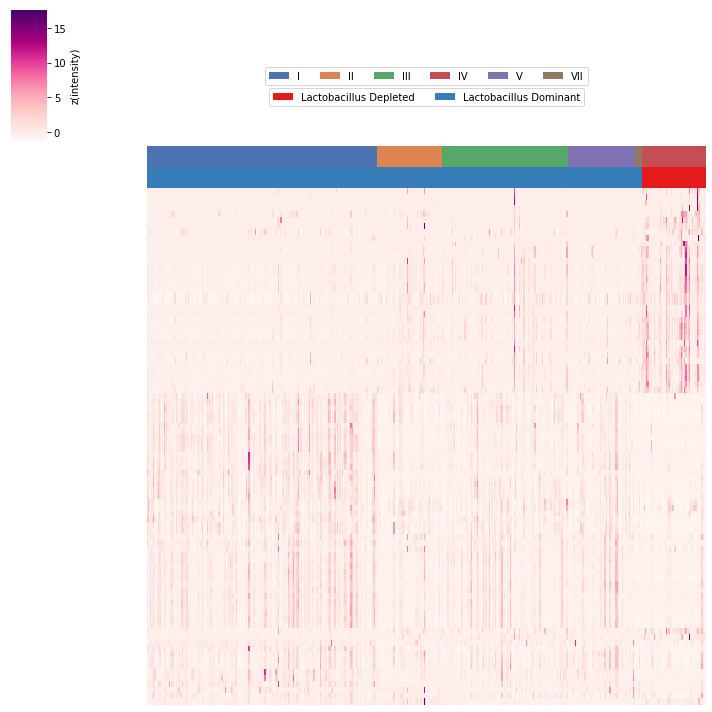

In [13]:
image_vmet = plotHeatmap(desi_neg_vmet, dnegMetLDep_vmet[image_vmet2.dendrogram_row.reordered_ind], 'CST', 'LDom', row_cluster=False)
image_vmet.savefig('./LinearMixedModels_DESI-MS/VMET_Heatmap_Figure1.png', dpi=150)
#image_vmet.savefig('VMET_Heatmap_Figure1.eps', dpi=150)
#image_vmet.savefig('VMET_Heatmap_Figure1.svg', dpi=150)